### My New Data World

As a new data scientist I have a desire for exploration. However, learning a new tool can be difficult to navigate. One must have tenacity and persevere. My first project in my data science adventures takes me to New York's MTA data. Here are some of my adventures with that data and learning Python.

#### Items we will explore
* BeautifulSoup
* Pandas DataFrames
* Datetime Objects
* Matplotlib

#### Imports

Pandas allows us to explore our data with a dataframe object which is where most of the exploration happens.
Datetime is what converts our date and time strings into a datetime object that allows for more advanced parsing of date information. Specifically helping us parse out weekdays from weekends or classifying dates by their week number which allows for grouping data into weeks.

In [49]:
from bs4 import BeautifulSoup
from scipy import stats
import requests
import re
import pandas as pd
import numpy as np
import datetime
import pylab
import matplotlib.pyplot as plt
from IPython.display import clear_output

pd.set_option('display.max_columns',40)

# jupyter magic to allow displaying figures in notebook and exporting as svg files
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Function Definition *myextract*

My function definition for *myextract* allows us to loop through a list of URLs to extract and combine the data into a holistic dataframe.

In [92]:
def myextract(myurls):
    df = []
    sz = len(myurls)
    for i,fname in enumerate(myurls):
        print('>'*i,'o','<'*(sz-i),str(int((i)/sz*1000)/10.0)+'% Complete')
        df.append(pd.read_csv(fname))
        clear_output(wait=True)
    print('>'*i,'o','<'*(sz-i),str(int((i+1)/sz*1000)/10.0)+'% Complete')
    return pd.concat(df)

#### Function Definition *get_daily_counts*

My function definition for *get_daily_counts* sanity checks that our delta from one day to the next looks right and in specific conditions will correct or obliterate the data so as to minimize larger impacts.

In [105]:
def get_daily_counts(row, max_counter):
    """ 
    Checks the results of delta calculation for abnormalities and handles them.
    Less than zero are flipped to positive. Greater than predefined max are reset to 0
    """
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        # if current entries is bad, use yesterday's count as proxy
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

#### URL List Setup, Data Extract, and Pandas DataFrame

To get the list of URLs we are going to extract from we start with extracting the data from the main URL.
We do this using a *request.get* and *BeautifulSoup* to then compile a list of URLs that match *'turnstile_17'* (which is all 2017 data). Calling the *myextract* function then loops through the URLs and creates the Pandas dataframe using *pd.concat()*.

In [51]:
myurl = "http://web.mta.info/developers/turnstile.html"
r = requests.get(myurl)
r.status_code

200

p = r.text
soup = BeautifulSoup(p,'lxml')
ahref = soup.find_all('a',href=re.compile('turnstile_1705'))
myurls = []
for i in ahref:
    myurls.append('http://web.mta.info/developers/'+i.get('href'))
df = myextract(myurls)

#### What questions do we want to answer and how will we use Python to answer them?

As we are dealing with volume and time much of our EDA will focus on thinking about measures of central tendency and variation. In my exploration I chose to focus on *median* and the inter-quartile range (*iqr*). Thus using these measures I have sought to answer the following questions.

For the year 2017:
* What are the top stations in terms of median?
* What does the inter-quartile range look like for those top stations?
* Can we use visualizations to help us digest this information as well?

#### Cleaning

Before we can answer these questions we need to get the data setup in the proper format.
At a high level this cleaning involves:

* Removing multiple time stamps in a single day
* Shifting data from one row to the next to calculate day-to-day deltas
* Adjusting or Eliminating data based on anomalies in the deltas

#### Removing Duplicates

As we are concerned with duplicates within a date and time we need to create that *DATE_TIME* column and then look for duplicates using the columns *C/A* *UNIT* *SCP* *STATION* and *DATE_TIME* as what we are keying off on.

```python
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
```

In [114]:
df.columns = [column.strip() for column in df.columns]
df['STATION'].apply(lambda x: x.strip())
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore")
df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES\
            .count().reset_index().sort_values("ENTRIES", ascending=False)
df_daily = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).ENTRIES.first().reset_index().copy()

#### Shifting our data to build day-to-day deltas

Here we create two new columns in our data called *PREV_DATE* and *PREV_ENTRIES*. We populate these columns using *.tranform* and a **lambda** function which *shifts* and grabs the prior date's *DATE* and *ENTRIES*. This is what finally allows us to create our *ENTRIES* field which contains our day-to-day deltas.

```python
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = \
                     (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\
                     .transform(lambda grp: grp.shift(1)));
```

In [115]:
df_daily[["PREV_DATE", "PREV_ENTRIES"]] = (df_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]\
                                           .transform(lambda grp: grp.shift(1)));

#### The *get_daily_counts* function to clean our *DAILY_ENTRIES* column

We use *.apply* to apply our *get_daily_counts* function to all of the data in *DAILY_ENTRIES*.
```python
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);
```

We see from above that our *get_daily_counts* function will do three things:
* Checks if the delta is going negative. In this case maybe the turnstile is going in reverse. We simply flip the number so it's incrementing instead of decrementing.
* Checks for numbers greater than 1 million. It will then assign the smaller of the previous or current counters.
* If it is still over a million it will simply obliterate the count by setting it to zero.

In [119]:
df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000);

### Onward to Analysis

Now that our data has been reasonably cleaned. Let us go back to the original questions posed.

#### What are the top stations in terms of median?

In order to analyze by station we first need to convert our *turnstile* based data into *station* based data. We do this with a *.groupby* *.sum()* and *.sort()* to sum up the station by day. Then we get the holistc median for a station over the entire time frame by doing a *.sort()* again, but this time without *.groupby()* on the *DATE* column and by doing an *.agg(['median'])*.

```python
df_daily_sta = (df_daily
              .groupby(['STATION','DATE'])['DAILY_ENTRIES']
              .sum()
              .reset_index()
              .sort_values(['median'], ascending=False)
              )
df_medians = (df_daily_sta
              .groupby(['STATION'])['DAILY_ENTRIES']
              .agg(['median'])
              .reset_index()
              .sort_values(['median'], ascending=False)
              )
df_medians_top5 = df_medians[:5]
```
This last line here takes our grouped and sorted data and splits out the top 5 stations by median.

In [165]:
df_daily_sta = (df_daily
                .groupby(['STATION', 'DATE'])['DAILY_ENTRIES']
                .sum()
                .reset_index()
                .sort_values(['DATE'])
                )
df_medians = (df_daily_sta
              .groupby(['STATION'])['DAILY_ENTRIES']
              .agg(['median'])
              .reset_index()
              .sort_values(['median'], ascending=False)
              )
df_medians_top5 = df_medians[:5]

#### Lets plot these top 5

```python
df_medians_top5.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Station')
plt.ylabel('Median')
plt.title("Median Ridership for Top 5 Stations")
plt.tight_layout()
plt.savefig('medians_t5.svg')
plt.show()
```

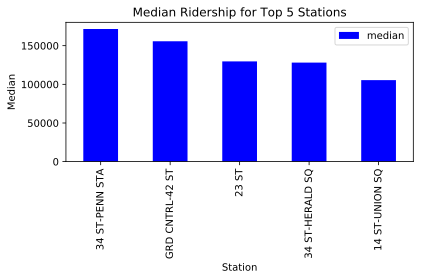

In [136]:
df_medians_top5.plot.bar(x='STATION',y='median',color='blue')
plt.xlabel('Station')
plt.ylabel('Median')
plt.title("Median Ridership for Top 5 Stations")
plt.tight_layout()
plt.savefig('medians_t5.svg')
plt.show()

#### NICE!

#### Now lets answer the question: What does the IQR look like?

We can obtain the IQR in a similar manner as we did for *median*, but instead of aggregating on median via *.agg(['median']) we will use the *scipy stats* call to iqr via *.agg(stats.iqr)*.
```python
df_iqr = (df_daily_sta
              .groupby(['STATION'])['DAILY_ENTRIES']
              .agg([stats.iqr])
              .reset_index()
              .sort_values(['iqr'], ascending=False)
              )
df_iqr_top5 = (df_iqr
                  .loc[(df_iqr.STATION.isin(df_medians_top5.STATION))]
                  .reset_index()
                  .sort_values(['iqr'], ascending=False)
                  )
```



In [137]:
df_iqr = (df_daily_sta
              .groupby(['STATION'])['DAILY_ENTRIES']
              .agg([stats.iqr])
              .reset_index()
              .sort_values(['iqr'], ascending=False)
              )
df_iqr_top5 = (df_iqr
                  .loc[(df_iqr.STATION.isin(df_medians_top5.STATION))]
                  .reset_index()
                  .sort_values(['iqr'], ascending=False)
                  )

#### Now lets plot these IQRs for the top 5

```python
df_iqr_top5.plot.bar(x='STATION',y='iqr',color='cyan')
plt.xlabel('Station')
plt.ylabel('Inter-Quartile Range')
plt.title("IQR for Top 5 Stations")
plt.tight_layout()
plt.savefig('iqr_t5.svg')
plt.show()
```

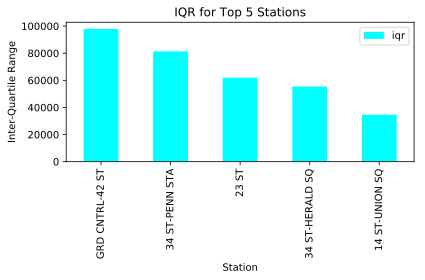

In [138]:
df_iqr_top5.plot.bar(x='STATION',y='iqr',color='cyan')
plt.xlabel('Station')
plt.ylabel('Inter-Quartile Range')
plt.title("IQR for Top 5 Stations")
plt.tight_layout()
plt.savefig('iqr_t5.svg')
plt.show()

#### Finally we will do some time series to see if there are any trends or abnormalities

The process to make time series data is to go back to our data frame that contained daily entries by station and parse it into a reasonable time frame for visualization. I chose to parse by weeks.



In [193]:
df_daily_sta5 = df_daily_sta.loc[(df_daily_sta.STATION.isin(df_medians_top5.STATION)),:]
df_daily_sta5['WEEK'] = pd.to_datetime(df_daily_sta5['DATE'], format="%m/%d/%Y").dt.week
df_wksta5 = (df_daily_sta5
              .groupby(['STATION','WEEK'])['DAILY_ENTRIES']
              .agg(['median'])
              .reset_index()
              .sort_values(['WEEK'], ascending=True)
              )

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [194]:
mrk = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|"]
mrkn = 0
a = df_wksta5
m = min(a.WEEK)
b = a.groupby(['STATION'])
c = b.loc([b.WEEK > 17])
fig, ax = plt.subplots(figsize=(10,4))

for key, grp in c.groupby(['STATION']):
    mrkn = mrkn % 24
    ax = grp.plot(ax=ax, kind='line', x='WEEK', y='median', label=key, marker=mrk[mrkn])
    mrkn += 1

plt.xticks(a.WEEK)
plt.legend(loc='upper left')
plt.savefig('Median_byWeek.svg')
plt.show();

AttributeError: Cannot access callable attribute 'loc' of 'DataFrameGroupBy' objects, try using the 'apply' method